# Example

## Preamble code

In [1]:
# Preliminary setup and imports

# For graphics
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("bmh")
%matplotlib inline
from IPython.display import display, HTML

# Solvers, math, etc.
import numpy as np
import pandas as pd
from pulp import *
import math

In [2]:
# For llovia

# Add to python path the folder where LLOVIA is located
import os,sys,inspect
currentdir = os.path.dirname(
    os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, os.path.join(currentdir, os.path.pardir, "src/solve"))
sys.path.insert(0, os.path.join(currentdir, os.path.pardir, "src/visualization"))

In [3]:
# imp.reload() forces reloading the module, which is useful
# during development
import imp
import lloovia
import lloovia_plot
imp.reload(lloovia)
from lloovia import (InstanceClass, Lloovia, LimitingSet, Problem, Solution)
from lloovia_plot import plot_solution_slots

In [4]:
# Auxiliar functions to draw a subplot which zooms another subplot
# (for Fig. 2 in paper)

from matplotlib.transforms import Bbox, TransformedBbox, \
    blended_transform_factory

from mpl_toolkits.axes_grid1.inset_locator import BboxPatch, BboxConnector,\
    BboxConnectorPatch

def connect_bbox(bbox1, bbox2,
                 loc1a, loc2a, loc1b, loc2b,
                 prop_lines, prop_patches=None):
    if prop_patches is None:
        prop_patches = prop_lines.copy()
        prop_patches["alpha"] = prop_patches.get("alpha", 1)*0.2
    c1 = BboxConnector(bbox1, bbox2, loc1=loc1a, loc2=loc2a, **prop_lines)
    c1.set_clip_on(False)
    c2 = BboxConnector(bbox1, bbox2, loc1=loc1b, loc2=loc2b, **prop_lines)
    c2.set_clip_on(False)
    prop_patches["ls"] = "solid"
    prop_patches["fc"] = (1,0,0,0.01)
    prop_patches["ec"] = (1,0,0,0.9)
    prop_patches["alpha"] = None
    bbox_patch1 = BboxPatch(bbox1, **prop_patches)
    bbox_patch2 = BboxPatch(bbox2, **prop_patches)

    prop_patches["alpha"] = 0.3
    p = BboxConnectorPatch(bbox1, bbox2,
                           # loc1a=3, loc2a=2, loc1b=4, loc2b=1,
                           loc1a=loc1a, loc2a=loc2a, loc1b=loc1b, loc2b=loc2b,
                           **prop_patches)
    p.set_clip_on(False)
    return c1, c2, bbox_patch1, bbox_patch2, p

def zoom_effect02(ax1, ax2, **kwargs):
    """
    ax1 : the main axes
    ax1 : the zoomed axes
    """
    tt = ax1.transScale + (ax1.transLimits + ax2.transAxes)
    trans = blended_transform_factory(ax2.transData, tt)

    mybbox1 = ax1.bbox
    mybbox2 = TransformedBbox(ax1.viewLim, trans)
    prop_patches = kwargs.copy()
    prop_patches["ec"] = "r"
    prop_patches["alpha"] = 0.2
    c1, c2, bbox_patch1, bbox_patch2, p = \
        connect_bbox(mybbox1, mybbox2,
                     loc1a=1, loc2a=4, loc1b=2, loc2b=3,
                     prop_lines=kwargs, prop_patches=prop_patches)
    ax1.add_patch(bbox_patch1)
    ax2.add_patch(bbox_patch2)
    #ax2.add_patch(c1)
    #ax2.add_patch(c2)
    ax2.add_patch(p)
    return c1, c2, bbox_patch1, bbox_patch2, p

In [5]:
# Parameters to generate paper-ready graphics
sb_white=dict(matplotlib.style.library["seaborn-whitegrid"])
sb_paper=dict(matplotlib.style.library["seaborn-paper"])
my_settings = {
    "axes.titlesize": 8,
    "axes.labelsize": 8,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "figure.figsize": (3.5, 2.5),
    'grid.linestyle': '-',
    "grid.linewidth": 0.5,
    "grid.alpha": 0.5,
    "lines.markersize": 3,
    "lines.linewidth": 0.8,
    "text.usetex": False,   
    "font.family": "serif",
    "pgf.rcfonts": False,
    "font.serif": [],   
    "font.sans-serif": [],
    "font.monospace": [],
}
paper_style = {}
for x in [sb_white, sb_paper, my_settings]:
    paper_style.update(x)
    
# Parameters to generate larger graphics, more adequete for the notebook
notebook_style = {}
my_settings = {
   "figure.figsize": (7, 5)
}
for x in [dict(matplotlib.style.library["seaborn-darkgrid"]),
          dict(matplotlib.style.library["seaborn-notebook"])]:
    notebook_style.update(x)

# Data for the problem

## Limiting Sets

$\def\LSetVMS{\text{LS}^\text{vms}}\def\LSetCORES{\text{LS}^\text{core}}\def\LSet{\text{LS}}$

From all considered cloud providers, the analyst has to choose a subset of regions and availability zones (Limiting Sets). For each Limiting Set, $\LSet_i$, the maximum number of running VMs, $\LSetVMS$ and maximum number of allocated cores, $\LSetCORES_i$, can be obtained from the data provided by the cloud operator

For this example we assume a cloud architecture like the one used by Amazon. Amazon imposes limits on the total number of on-demand VMs per region, so regions are limiting sets for that kind of VMs. However, in the case of reserved VMs, the limitation is per availability zone (there can be several zones per region), so zones are limiting sets for reserved VMs. Amazon does not impose any limit for the number of cores per region or zone.

To keep the example simple, we assume that Region 1 can only be used to deploy on-demand VMs, while Region 2 can be used for both on-demand and reserved VMs. Therefore each region is a limiting set for the on-demand VMs, while the zones inside Region 2 are limiting sets for the reserved VMs. The total number of VMs that can be deployed would be 30 on-demand VMs (15 in each region) plus 24 reserved VMs (12 in each zone inside Region 2).

In [6]:
# Define the different regions and zones, and set the limits
region1 = LimitingSet("Region1",  max_vms=15)    # Those are for on-demand
region2 = LimitingSet("Region2",  max_vms=15)
zone1   = LimitingSet("Region2 Z1", max_vms=12)  # Those are for reserved
zone2   = LimitingSet("Region2 Z2", max_vms=12)

LS = [region1, region2, zone1, zone2]

In [7]:
# Generate table to summarize limiting sets using paper's notation
df_ls = pd.DataFrame([OrderedDict(Str=str(i),**i.__dict__) for i in LS])
df_ls = df_ls[["name", "max_vms", "max_cores"]]
df_ls.index.name  = "$j$"
LSjvms= r"$\text{LS}_j^\text{vms}$"
LSjcores = r"$\text{LS}_j^\text{cores}$"
LSj = r"$\text{LS}_j$"
df_ls.columns = [LSj, LSjvms, LSjcores]
df_ls[LSjcores] = "$\infty$"
display(df_ls)

,$\text{LS}_j$,$\text{LS}_j^\text{vms}$,$\text{LS}_j^\text{cores}$
$j$,,,
0,Region1,15,$\infty$
1,Region2,15,$\infty$
2,Region2 Z1,12,$\infty$
3,Region2 Z2,12,$\infty$


## Instance Classes

$\def\IClass{\text{IC}}\def\maxvm{\text{max}^\text{vm}}\def\perf{\text{perf}}$

For each limiting set, the analyst has to choose a subset of all offered VM types within that limiting set. This is the concept of Instance Class presented in the model. For each Instance Class, $\IClass_i$, the analyst has to collect some cloud operator provided information, such as the price per hour, $p_i$, the number of cores, $c_i$, the limit imposed for that VM type, $\maxvm_i$, etc. 

In addition, the performance, $\perf_i$, of each instance class is also required, but this depends on the kind of application running in that VM, and thus must be found by benchmarking.

Next cells define and show the Instance Classes chosen for this example. These are made up examples, and do not correspond to any real VM tpye offered by any particular cloud provider. The performance is assumed to be in the same units as the workload that has to be fulfilled, for example, in requests per hour (rph). Note that each IC belongs to a particular limiting set, and that reserved ICs have no limit on the number of instances per type (as it is the case for Amazon). We assume for this example that the performance of each VM type is the same across all regions; however, the price is different. The number of cores of each VM (column $c_i$) will not be used in this example, since the provider does not impose a limit on the total number of cores, but other providers (e.g., Azure) may enforce such a limit. 


In [8]:
# Define the instance clasess. Each one pertains to a limiting set
# and in case of the on-demand ones they set also a max_vms per type
instance_classes = [           # Price, performance
    # on-demand
    InstanceClass("small", region1, 0.05,   5,  max_vms=10),
    InstanceClass("large", region1, 0.11,   10, max_vms=10, provides={"cpus": 2} ),
    InstanceClass("small", region2, 0.052,  5,  max_vms=10),
    InstanceClass("large", region2, 0.12,   10, max_vms=10, provides={"cpus": 2} ),
    # Reserved
    InstanceClass("small", zone1,   0.038,  5,  reserved=True, max_vms=None),
    InstanceClass("large", zone1,   0.09,  10,  reserved=True, max_vms=None, provides={"cpus": 2} ),
    InstanceClass("small", zone2,   0.038,  5,  reserved=True, max_vms=None),
    InstanceClass("large", zone2,   0.09,  10,  reserved=True, max_vms=None, provides={"cpus": 2} ),
]


In [9]:
def prettify_names(instance_classes, amazon_or_azure=False):
    """Generate readable instance names from instance attributes"""
    import re
    colnames=[]
    regions = set()
    cont_regions = 0
    n_provider=""
    for col in instance_classes:
        if col.reserved:
            n_res = " [res]"
            n_zone = re.search(r'AZ(\d+)',col.cloud.name)
            if n_zone:
                n_zone = "-Z{}".format(n_zone.groups()[0])
            else:
                n_zone = ""
        else:
            n_res = " [dem]"
            n_zone = ""
        if "(" in col.cloud.name:
            m = re.search(r'(.*?) \((.*?)\)', col.cloud.name)
            n_region = "{}-{}".format(m.group(1), m.group(2))
            if amazon_or_azure:
                n_provider = "Amazon, "
        else:
            n_region = col.cloud.name
            if amazon_or_azure:
                n_provider = "Azure, "

        n_cloud = " ({}{}{})".format(n_provider, n_region, n_zone)
        name = "{}{}{}".format(col.name, n_cloud, n_res)
        colnames.append(name)
    return colnames

In [10]:
def display_table_of_instance_classes(instance_classes):
    # Generate table to summarize instance classes using paper's notation
    df_ic = pd.DataFrame([OrderedDict(Str=i,**i.__dict__) for i in instance_classes])
    # Dictionary to convert to latex formulae the name of each field
    d = OrderedDict([ 
            ("IC_i", r"$\text{IC}_i$"),
            ("ls_i", r"$\text{ls}_i$"),
          ("c_i",    r"$c_i$"),
         ("max_i" ,  r"$\text{max}_i$"),
        ("type_i" ,  r"$\text{type}_i$"),
        ("perf_i" ,  r"$\text{perf}_i$"),
           ("p_i" ,  r"$p_i$ (\$/h)"),
         ("rsv_i" , r"$\text{rsv}_i$")
            ])
    # Select the columns to display
    df_ic = df_ic[["Str", "name", "max_vms", "cloud", 
                   "price", "performance", "cores", "reserved" ]]
    # Translate those columns to LaTeX using paper's notation
    df_ic.columns = [d[key] for key in ["IC_i", "type_i", "max_i", "ls_i",
                                        "p_i", "perf_i", "c_i", "rsv_i"]]
    df_ic.index.name = "$i$"

    # Put infinity in unset limits
    df_ic[d["max_i"]][df_ic[d["max_i"]] == 0] = r"$\infty$" 

    # Translate clouds names into LimitingSet indexes (j)
    aux = df_ic[d["ls_i"]].values
    df_ic[d["ls_i"]] = [LS.index(ls) for ls in aux]

    # Prettify names of the InstanceClasses to match them to the ones used in plots
    df_ic[d["IC_i"]] = prettify_names(df_ic[d["IC_i"]].values)
    display(df_ic)

In [11]:
display_table_of_instance_classes(instance_classes)

,$\text{IC}_i$,$\text{type}_i$,$\text{max}_i$,$\text{ls}_i$,$p_i$ (\$/h),$\text{perf}_i$,$c_i$,$\text{rsv}_i$
$i$,,,,,,,,
0,small (Region1) [dem],small,10,0,0.050,5,1,False
1,large (Region1) [dem],large,10,0,0.110,10,2,False
2,small (Region2) [dem],small,10,1,0.052,5,1,False
3,large (Region2) [dem],large,10,1,0.120,10,2,False
4,small (Region2 Z1) [res],small,$\infty$,2,0.038,5,1,True
5,large (Region2 Z1) [res],large,$\infty$,2,0.090,10,2,True
6,small (Region2 Z2) [res],small,$\infty$,3,0.038,5,1,True
7,large (Region2 Z2) [res],large,$\infty$,3,0.090,10,2,True


## Workload

For Phase I, a prediction of the workload for each time slot in a whole reservation period (LTWP) is required. Our method does not require nor assume any prediction model, since it only requires a list of predicted load values, one for each time slot.

For this example, the reservation period will be one year, divided into 8760 time slots which represent each hour. The predicted workload will be modeled as a uniform random variable between 90 and 110, plus a sinusoid of amplitude 30 and period of one week, to represent the variations among weekdays, plus another sinusoid of amplitude 30 and period equal to 573 days, to represent slow variations among years. To make the example more interesting, a spike was added around time slot 5660 in which the load is 150 units larger than usual. This spike makes less obvious what is the optimal load-level which has to be covered by reserved instances.

The code below generates a `csv` file with an instance of the described workload. 

To reproduce the same results shown in the paper, don't re-run this code. Use instead the provided "example_load.csv"

```python
year = 8760  # Number of time slots in the year
load = np.ones(year)*100                                  # Base load (100)
load = load + np.random.rand(year)*20                     # Random variability (±20)
load = load + np.sin(np.arange(year)/year*4)*30           # Stational cycle (±30)
load = load + np.sin(np.arange(year)/year*2*np.pi*52)*30  # Weekly cycle (±30)
load = load.clip(min=0)  # Remove negative values
load = np.floor(load)    # Make the load integer
load[5660:5670] += 150   # Insert spike at 5560--5670

# Save this load to make the notebook reproducible
df = pd.DataFrame(load)
df.columns=["load"]
df.index.name="Time slot"
df.to_csv("example_load.csv")
```

Load into the notebook the pre-generated workload example.

In [12]:
# Read pre-generated load from csv
df = pd.read_csv("../data/processed/traces_example_simple.csv", index_col=0)
workload=df.load.values

Plot it for the whole year, with a zoom around the spike area.

/home/jldiaz/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


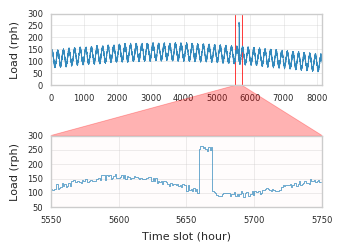

In [13]:
zoom = (5550, 5750)  # xlimits to zoom in the auxiliar plot

with matplotlib.style.context(paper_style):
    f, ax = plt.subplots(2)

    # First subplot, whole year
    df.plot(ax=ax[0], linestyle="steps", legend=False, linewidth=0.5) 
    #, figsize=(3.3,3))
    f.subplots_adjust(hspace=0.7)
    ax[0].set_ylabel("Load (rph)")
    ax[0].set_xlabel("")

    # Second subplot, zoom around region of interest
    df[slice(*zoom)].plot(ax=ax[1], linestyle="steps", linewidth=0.5, legend=False)
    ax[1].set_ylabel("Load (rph)")
    ax[1].set_xlabel("Time slot (hour)")
    ax[0].set_xlim(0, 8160)
    ax[1].set_xlim(*zoom)

    # Connect subplots to show visually the zoom effect
    zoom_effect02(ax[1], ax[0], color="r", linestyle="dashed", linewidth=0.6)
    plt.gcf().savefig("../reports/figures/fig-002-synthetic-LTWP.pgf", bbox_inches = 'tight')
    plt.show()

The problem input is composed of the set of instance classes, plus the workload. It can be saved in a pickle file for reusing it in a different notebook.

In [14]:
problem = Problem(instance_classes, workload)
problem.save("../data/interim/example_inputs.pickle")

In [15]:
# To read a saved problem, a method is provided
problem = Problem.load("../data/interim/example_inputs.pickle")

In [16]:
print(problem, problem.instances)

Problem with 8 instance classes and 8760 timeslots [small_Region1, large_Region1, small_Region2, large_Region2, small_Region2 Z1_R, large_Region2 Z1_R, small_Region2 Z2_R, large_Region2 Z2_R]


# Histogram computation

The LTWP is composed of 8760 values, one per time slot, several of them probably being repeated. Computing the frequency histogram of each possible load level can help to reduce the amount of data used as input, and thus the size of the LP problem to solve.

In [17]:
H = lloovia.get_load_hist_from_load(problem.workload)

# Convert it to dataframe for easier plotting and inspection
dfh=pd.DataFrame(list(H.items()))
dfh.columns=["Load level", "Count"]
dfh = dfh.sort_values(by="Load level")
dfh = dfh.set_index("Load level")

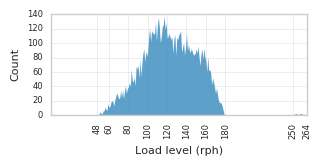

In [18]:
# Plot the histogram

# Fill with zero all load-levels not present in dfh
all_levels = pd.DataFrame(list(range(int(dfh.index.max()))), columns=["Load level"])
all_levels = all_levels.set_index("Load level")
all_levels = pd.concat([all_levels,dfh], axis=1).fillna(method="bfill", limit=2)


# Plot the resulting data as area-plot
with matplotlib.style.context(paper_style):
    ax = all_levels.plot(kind="area", grid=True, alpha=0.8, 
                     figsize=(3.3,1.3),   # Size for paper
                     linewidth=0, legend=False)

    # Select a subset of the xticks to be labelled
    ticks = [48] + list(range(60,185,20)) + [250, 264]
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks, rotation=90)
    ax.set_ylabel("Count")
    ax.set_xlabel("Load level (rph)")
    plt.gcf().savefig("../reports/figures/fig-003-histogram.pgf", bbox_inches = 'tight')

It can be seen in this plot that the minimum predicted load is 48, and the maximum is 264, which correspond to the spike. Thus, we can expect $264-48=216$ different load values at maximum. However, it should be noted that there are no load values between 180 and 250, so the effective number of load values will be in fact lower (139 in this example).

This shows one of the advantages of switching from the time-slot domain to the load-level domain. The size of the input data is reduced from 8760 to 139 in this example. In the worst case, in which the load levels never repeat among time slots, this transformation would not reduce the size of the problem, but it would not increase it either.

A second advantage is that we have control over the size of the input, because the size of the histogram can be further reduced by using binning when computing it. For example, if 12 bins are used, the resulting histogram will consider only 12 different load levels, between 0 and the maximum. In fact, since some of the bins could be empty, the number of effective load levels may be less than 12. 

## Binning

Now, recompute the histogram with 10 bins (divide the range min(load)-max(load) in 10 parts). We illustrate in this notebook how the histogram can be computed. In the normal use of Lloovia this is not neccessary, since the histogram is automatically computed by Lloovia when the parameter `max_bins` is used.

In [19]:
bin_size = (max(problem.workload) - min(problem.workload)) / 10
number_of_bins = int(max(problem.workload) / bin_size)

# We substract epsilon to each load level, so that it falls inside the
# bin whose right mark is that load level
epsilon = 1e-6
h = np.histogram(problem.workload-epsilon, bins=number_of_bins, 
                 range=(0, max(problem.workload)))
# Convert this histogram into a dictionary whose keys are load-levels
# and the values are the corresponding count. We take the right mark of each
# bin as representative of the bin
H10 = dict(zip(h[1][1:], h[0]))
H10

{22.0: 0,
 44.0: 0,
 66.0: 181,
 88.0: 833,
 110.0: 2048,
 132.0: 2465,
 154.0: 2027,
 176.0: 1178,
 198.0: 18,
 220.0: 0,
 242.0: 0,
 264.0: 10}

In [20]:
# remove empty bins to keep only effective load levels
H10 = {l: count for l, count in H10.items()  if count>0}
H10

{66.0: 181,
 88.0: 833,
 110.0: 2048,
 132.0: 2465,
 154.0: 2027,
 176.0: 1178,
 198.0: 18,
 264.0: 10}

In [21]:
# Convert it to pandas dataframe for easier plotting and inspection
dfh10 = pd.DataFrame(list(H10.items()))
dfh10.columns = ["Load level", "Count"]
dfh10 = dfh10.sort_values(by="Load level")
dfh10 = dfh10.set_index("Load level")

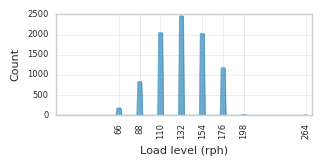

In [22]:
# Plot the histogram

# Fill with zero all load-levels not present in dfh10
all_levels = pd.DataFrame(list(range(int(dfh10.index.max()))), 
                          columns=["Load level"])
all_levels = all_levels.set_index("Load level")
all_levels = (pd.concat([all_levels,dfh10], axis=1)
                      .fillna(method="bfill", limit=2)
                      .fillna(method="ffill", limit=2))

# Plot the resulting data as area-plot
with matplotlib.style.context(paper_style):
    ax = all_levels.plot(kind="area", 
                         figsize=(3.3,1.3), # Size for paper
                         alpha=0.7, xlim=(0,270),
                         linewidth=0.5, legend=False)

    # put x labels only for the resulting effective load levels
    ticks = list(map(int, sorted(list(H10.keys()))))
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks, rotation=90)
    ax.set_ylabel("Count")
    ax.set_xlabel("Load level (rph)")
    plt.gcf().savefig("../reports/figures/fig-004-histogram-binned.pgf", bbox_inches = 'tight')

# Solving, Phase I

## No binning (optimal solution)

$\def\ICres{\text{IC}^\text{res}}\def\ICdem{\text{IC}^\text{dem}}$

Once all required information is gathered, it is used to create the LP problem. In this example, the problem will have four integer variables $Y_i$ which represent the number of reserved VMs for each $\ICres_i$ to allocate during the whole reservation period, plus $4\times|H|$ integer variables $X_{il}$ which represent the number of on-demand VMs for each $\ICdem_i$ to allocate for each predicted load level (being $|H|$ the number of non-empty bins in the histogram). In our case, if no binning is performed, $|H|=139$, so the total number of variables in the LP problem would be 560. If we use binning with 12 bins, then $|H|=8$ as already shown and the total number of variables is reduced to 36.

The number of constraints in the problem is also related to the size of $|H|$, since performance restrictions have to be satisfied for each load level. In this example, without binning, the total number of constraints is 1251. Using 12 bins the number of constraints in the problem is reduced to only 72.

In [23]:
phase_I = lloovia.PhaseI(problem, title="Example, no binning")
phase_I.solve()

Several statistics about the status (optimallity) of the solution, the time required to create and solve the problem, the parameters passed to the solver, and a copy of the problem, can be retrieved from `phase_I.solution`. See for example the solving stats:

In [24]:
phase_I.solution.solving_stats

SolvingStatsI(max_bins=None, workload=LlooviaHistogram(139 elements), frac_gap=None, max_seconds=None, creation_time=0.09760162001475692, solving_time=0.13908485800493509, status='optimal', lower_bound=None, optimal_cost=9015.216000000004)

The complete allocation for each load-level is also available as a pandas DataFrame, and from it several results can be obtained, such as the total cost of the proposed allocation, which has to be equal to the optimal cost found by the solver (see above)

In [25]:
print("Total cost: %f" % phase_I.solution.get_cost("total"))
print("Cost of reserved instances: %f" % phase_I.solution.get_cost("reserved"))
print("Cost of on-demand instances: %f" % phase_I.solution.get_cost("ondemand"))

Total cost: 9015.216000
Cost of reserved instances: 6990.480000
Cost of on-demand instances: 2024.736000


In [26]:
print("The average load is: %f" % np.array(problem.workload).mean())
print("Reserved instances give a performance of: %f" % phase_I.solution.compute_reserved_performance())

The average load is: 122.048744
Reserved instances give a performance of: 105.000000


The solution from Phase I is the optimal number of reserved and on-demand VMs that should be allocated at each possible predicted load level to minimize the cost while satisfying performance constraints and the limits enforced by the cloud provider. This solution is stored in a table, whose index is all the possible load levels (in the LTWP), and the rows store the optimal number of VMs for each $\text{IC}_i$ to allocate for that load level. In addition, the value of the objective function is the optimal cost, assuming that the actual load that will be present when the system is in production is equal to the predicted LTWP. In this example this cost is 9015.216.

In [27]:
allocation = phase_I.solution.allocation
# Show part of the solution, for example, the optimal allocation for l=160
l=160
allocation.loc[l]

small_Region2 Z1_R    12.0
small_Region2 Z2_R     9.0
large_Region2 Z2_R     0.0
large_Region2 Z1_R     0.0
small_Region2          1.0
large_Region2          0.0
large_Region1          0.0
small_Region1         10.0
Name: 160.0, dtype: float64

This information can be represented also as a graph, shown below. In this graph, the x-axis shows all possible load levels in the LTWP, and for each one of them the optimal number of VMs is represented as a stacked bar, using different colours for each IC. The legend for this graph is shown separately to save space, since it is shared with other graphs shown in this notebook.

In [28]:
# Define some colors for the following plots
import matplotlib.cm as cm
mycolors = [
    cm.Greens(0.6), cm.Greens(0.9), # Those are for reserved VMs in any zone
    cm.Blues(0.6), cm.Blues(0.9),   # Those are for on-demand VMs in Region1
    cm.Reds(0.6), cm.Reds(0.9),     # Those are for on-demand VMs in Region2
]

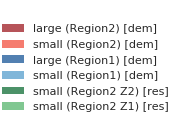

In [29]:
# Plot the legend (the same for all the plots to follow)
import matplotlib.patches as mpatches

# Create auxiliar plot to get the colors and labels for the legend
with matplotlib.style.context(paper_style):
    aux = plot_solution_slots(allocation, linewidth=0, legend=False,  
                              amazon_or_azure=False, colors=mycolors)
    plt.close() # Close the plot to avoid displaying it

    # Draw a separate legend
    patches, labels = aux.get_legend_handles_labels()
    f = plt.figure(figsize=(1,1))
    ax = f.add_subplot(111)
    ax.set_axis_off()  #turn off the axis 
    ax.legend(reversed([mpatches.Rectangle((0, 0), 1, 1, fc=handle.get_color(),
                                                  linewidth=handle.get_linewidth(),
                                                  alpha=handle.get_alpha())
                               for handle in patches]) , reversed(labels))
    
    plt.gcf().savefig("../reports/figures/fig-007-legend.pgf", bbox_inches = 'tight')

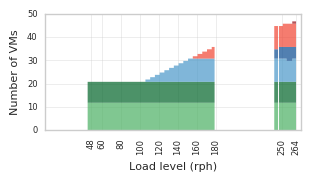

In [30]:
# Plot the allocation (using load levels as x-axis)

# First, fill with zero the load levels absent from the input histogram
all_levels = pd.DataFrame(list(range(int(dfh.index.max()))), columns=["Load level"])
all_levels = all_levels.set_index("Load level")
allocation.index.name="Load level"
all_levels = pd.concat([all_levels, allocation], axis=1).fillna(method="bfill", limit=3)

# Plot the result as a stacked area graph
with matplotlib.style.context(paper_style):
    p = plot_solution_slots(all_levels, linewidth=0, 
                            figsize=(3.3, 1.5), # Size for paper
                            #figsize=(8,4),
                            legend=False,  amazon_or_azure=False, colors=mycolors)
    p.set_xlabel("Load level (rph)")
    p.set_ylabel("Number of VMs")
    p.set_xlim(0,270)

    # Select a subset of x-ticks to label
    ticks = [48] + list(range(60,185,20)) + [250, 264]
    p.set_xticks(ticks)
    p.set_xticklabels(ticks, rotation=90)
    plt.gcf().savefig("../reports/figures/fig-005-optimal-alloc-vs-load.pgf", bbox_inches = 'tight')

The gaps in this plot correspond to load levels which do not appear in the LTWP. It can be seen that the optimal number of reserved VMs is 21 VMs of type small (12 in zone 1, and 9 in zone 2), and the number of on-demand VMs depends on the value of the load level. When the load is under 110 rph, the reserved VMs are enough to fulfill it. As the load level increases, more VMs of type small are purchased in Region 1 (which is cheaper) until the limit of 10 VMs of type small is reached, for a load level around 150. Then, as the load continues increasing, small VMs in Region 2 are added. The optimal allocation for higher load values is more interesting. For a load level of 254 the absolute limit of 15 VMs for Region 1 is reached. In addition, there are 10 small VMs allocated in Region 2. For a load level of 256 the solution exchanges one small VM for a large VM in the same region, so that the limit of 15 is still preserved and the performance is greater. However, for higher values of load, such as 264, it is more cost-effective to switch again to 10 small and 5 large VMs in Region 1, and allocate a new large VM in Region 2. The purpose of this explanation is to show how the determination of the optimal number of VMs of each class, for each load level, is a complex task, even for a simple example such as the one presented, which cannot be solved without the aid of a tool.

In [31]:
# Convert the solution from the load-level domain to the time-slot domain
def load_levels_to_slots(load, allocation):
    bins = allocation.index
    q_index = np.digitize(load, bins, right=True)
    npsol = np.take(allocation.get_values(), q_index, axis=0)
    return pd.DataFrame(npsol, columns=allocation.columns)

allocation_t = load_levels_to_slots(problem.workload, allocation)

The allocation for Phase I can be expanded in time again, as shown in next plot, using for each time slot the optimal allocation given by the solution for the load level present in that time slot.

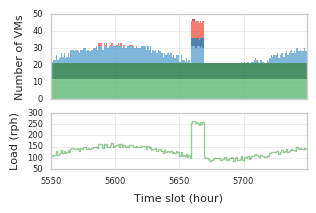

In [32]:
# Plot again the solution, but using time slots as x-axis
# Instead of plotting the whole year, we show only a region of interest 
# around the spike
xlim = zoom

with matplotlib.style.context(paper_style):
    # Two subplots, one for the allocations, another for the workload
    f, axarr = plt.subplots(2, sharex=True, gridspec_kw = {'height_ratios':[3, 2]})

    # 1) Plot the allocations as stacked areas
    plot_solution_slots(allocation_t, ax = axarr[0], linewidth=0, colors=mycolors,
                       amazon_or_azure=False, 
                        figsize=(3.3,2),   # Size for  paper
                        # figsize=(8,6),
                       xlim = xlim, legend=False)
    axarr[0].set_ylabel("Number of VMs")

    # 2) Plot the workload as a stepwise function
    sli = slice(*xlim)
    r = range(*xlim)
    axarr[1].step(r, problem.workload[sli], alpha=0.4, color="green", linewidth=1)
    axarr[1].set_ylabel("Load (rph)")
    axarr[1].set_xlabel("Time slot (hour)")
    f.subplots_adjust(hspace=0.2)
    plt.gcf().savefig("../reports/figures/fig-006-optimal-alloc-vs-time.pgf", bbox_inches = 'tight')

## Binning (10 bins, 8 effective load levels)

In some real-world cases, when the number of different instance classes is very large, and the LTWP does not repeat values, so that the histogram does not help to reduce the size of the problem, the time to solve the LP problem required for Phase I can be prohibitively long. For these cases, the proposed approximation is to reduce the size of the problem by using bins when computing the histogram.

Using the histogram with the 10 bins already computed, instead of the full histogram, the LP problem for this example can be generated and solved in 0.024s. However, the solution is no longer optimal, since much information has been lost in the binning.

In [33]:
phase_I_10 = lloovia.PhaseI(problem, title="Example, no binning")
phase_I_10.solve(max_bins=10)

The cost of this allocation is not optimal. It will be enhanced in Phase II.

In [34]:
allocation_10 = phase_I_10.solution.allocation
print("Cost of this allocation:", phase_I_10.solution.get_cost())

Cost of this allocation: 9718.572


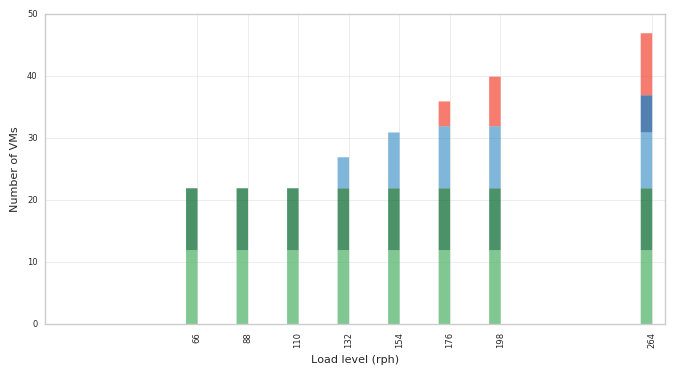

In [35]:
# Plot the solution with load-levels in x-axis

# First, fill with zeros the load-levels not present in the solution
all_levels = pd.DataFrame(list(range(int(dfh10.index.max()))), columns=["Load level"])
all_levels = all_levels.set_index("Load level")
allocation_10.index.name="Load level"
all_levels = pd.concat([all_levels, allocation_10], axis=1).fillna(method="bfill", limit=4)

# Plot this solution
with matplotlib.style.context(paper_style):
    p = plot_solution_slots(all_levels,  linewidth=0, legend=False,
                            # figsize=(3.3, 1.6),   # Size for the paper version
                            figsize=(8,4),
                            amazon_or_azure=False, colors=mycolors)

    # Put labels only at xticks present in the solution
    ticks = [int(round(t)) for t in H10.keys()]
    p.set_xticks(ticks)
    p.set_xticklabels(ticks, rotation=90)
    p.set_xlabel("Load level (rph)")
    p.set_ylabel("Number of VMs")
    p.set_xlim(0,270)
    plt.show() 

The plot shows the solution for this case. In this solution, the optimal allocation is found only for a small subset of predicted workloads, which are the ones labeled in the x-axis (coincident with the ones in the histogram obtained with binning). 

In [36]:
# Convert the solution from the load-level domain to the time-slot domain
allocation_10_t = load_levels_to_slots(problem.workload, allocation_10)

To plot this solution on the time axis, as shown below, each load level is quantized to the closest above in the set of effective load levels produced by the binning. The lower part of that plot shows this quantization.

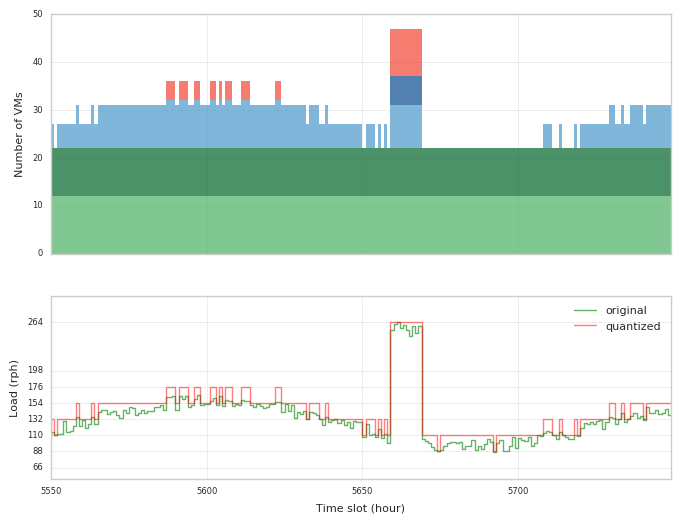

In [37]:
# Plot again the solution, but using time slots as x-axis
# Instead of plotting the whole year, we show only a region of interest 
# around the spike

xlim = zoom



# Plot the allocations
with matplotlib.style.context(paper_style):
    # Two subplots, one for the allocation, another for the workload
    f, ax = plt.subplots(2, sharex=True, 
                         gridspec_kw = {'height_ratios':[3, 2.3]})
    plot_solution_slots(allocation_10_t, ax = ax[0], linewidth=0, 
                        colors=mycolors, amazon_or_azure=False, xlim = xlim, 
                        legend=False,
                        # figsize=(3.3,3),    # Size for the paper version
                        figsize=(8,6),
                         )
    ax[0].set_ylabel("Number of VMs")

    # Plot the workload, showing the quantization effect of binning
    r = range(*xlim)
    sli = slice(*xlim)
    ax[1].step(r, problem.workload[sli], label="original", color="green", 
               alpha=0.6, linewidth=1)

    # Quantize the load and plot it too
    bins = sorted(list(H10.keys()))
    load_q = np.take(bins, np.digitize(problem.workload, bins, right=True))
    ax[1].step(r, load_q[sli], alpha=0.5, color="red", label="quantized", 
               linewidth=1)

    # Label y-ticks in the load only for effective load levels
    ax[1].set_yticks(list(H10.keys()))
    ax[1].set_ylabel("Load (rph)")
    ax[1].set_xlabel("Time slot (hour)")
    ax[1].legend()
    f.subplots_adjust(hspace=0.2)
    plt.show()

Although the solution of Phase~I is very different when using binning compared to the optimal one when no binning is used, it is our hypothesis that the number of reserved VMs would be very close to the optimal one. In this example, indeed, the difference is only one extra reserved VM of type small in Zone 2. Other notebooks will explore this with more detail, for synthetic workloads and real-world case studies.

The solution from Phase I can be saved in a file to make it more independent of Phase II, which can be performed in a different notebook or process.

In [38]:
phase_I_10.solution.save("../data/interim/example_phase_I_10_solution.pickle")

# Solving, Phase II

To solve Phase II the required inputs are: the characteristics of instance classes used in Phase I (we assume here that these characteristics are fixed in time, but it would be trivial to allow the price or performance data to be updated at each time slot), the solution obtained in Phase I, and the STWP for the next time slot. With this information we proceed as follows.

We will apply Phase II only to the second example, which is the one using binning.

In [39]:
# Intialize the problem for PhaseII with the same instances used for phase I
# The workload stored in the problem for phase II is the STWP for each timeslot
# in the next reservation period, and it will not be available in a real scenario, 
# in which typically we will have the STWP for the next hour only. 
# The use of this parameter is explained later. 
problemII = Problem(problem.instances, problem.workload)
phase_II = lloovia.PhaseII(problemII, phase_I_10.solution, title="Example phase II")

At each new timeslot, when the value of STWP for the next hour is known, the function `phase_II.solve_timeslot()` is called again, passing as argument the STWP for the next timeslot. This is the intended use of Lloovia during the online phase. Internally `phase_II` caches in the attribute `_solutions` the solution for each solved load-level, so that if load levels repeat the solution is readly available.

For example, lets assume that the next three timeslots will have a STWP of `250`, `90` and `130`.

In [40]:
phase_II.solve_timeslot(250)
# One our later
phase_II.solve_timeslot(90)
# One our later
phase_II.solve_timeslot(130)

We can inspect the stored `_solutions` and the data for any particular one using the loadlevel as index.

In [41]:
# See how many solutions have been stored so far
phase_II._solutions

OrderedDict([(250, optimal solution with cost 1.46),
             (90, trivial solution with cost 0.0),
             (130, optimal solution with cost 0.2)])

In [42]:
# Inspect the solution for workload=250
print(phase_II._solutions[250].solving_stats)
display(phase_II._solutions[250].allocation)

SolvingStatsTimeslot(workload=250, ondemand_workload=140.0, frac_gap=None, max_seconds=None, creation_time=0.0008692329283803701, solving_time=0.010572892031632364, status='optimal', lower_bound=None, optimal_cost=1.46)


,small_Region1,large_Region1,small_Region2,large_Region2
140.0,10.0,4.0,10.0,0.0


For analysis purposes we can act as if the STWP for the next 8760 hours is already available, and compute all the solutions in a loop. This is what method `solve_period()` does, and uses as STWP for each hour the values stored in `problem_II.workload`. In this particular example these values coincide with the LTWP used in Phase I, i.e., LTWP was a perfect prediction.

In [43]:
phase_II.solve_period()

Lloovia stitched the solutions for each timeslot in a single global solution, which can be saved to be used in a different notebook:

In [44]:
phase_II.solution.save("../data/interim/example_phase_II.pickle")

It provides attributes and methods to obtain statistics, allocation, cost, etc. analogous of the ones in Phase I solution.

In [45]:
print(phase_II.solution)
print(phase_II.solution.solving_stats)

optimal solution with global ondemand cost 1708.3399999999833
SolvingStatsII(workload=array([ 105.,  120.,  114., ...,   86.,   94.,   85.]), default_frac_gap=None, default_max_seconds=None, global_creation_time=0.06923886726144701, global_solving_time=0.8986371295759454, global_status='optimal', global_cost=1708.3399999999833, individual_status=StatusList({'trivial', 'optimal'}))


In [46]:
print("Cost for the whole year:   %f" % phase_II.solution.get_cost())
print("Compare with optimal:      %f" % phase_I.solution.get_cost())
print("Compare with Phase I only: %f" % phase_I_10.solution.get_cost())

Cost for the whole year:   9031.700000
Compare with optimal:      9015.216000
Compare with Phase I only: 9718.572000


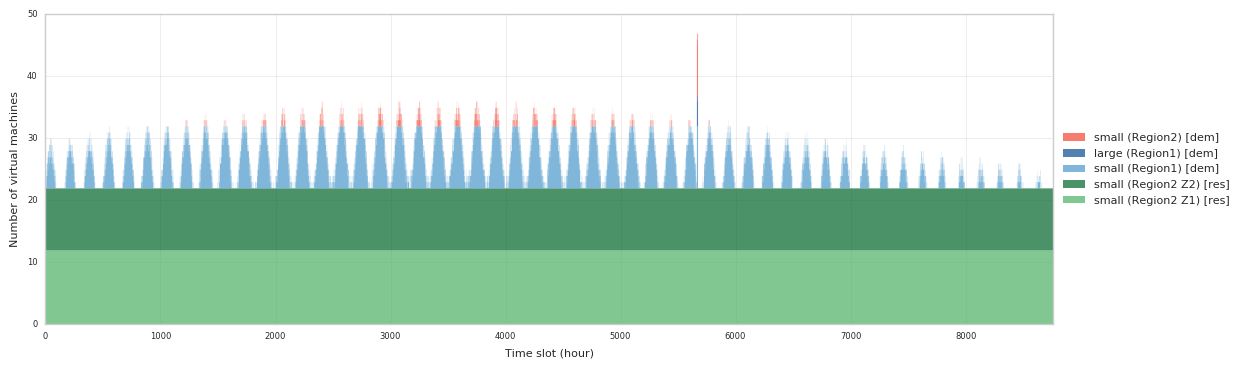

In [47]:
# Plot the optimal allocation for each time-slot for the whole year 
# (this plot was not shown in the paper)
with matplotlib.style.context(paper_style):
    p = plot_solution_slots(phase_II.solution.get_allocation(), linewidth=0, colors=mycolors,
                       amazon_or_azure=False, figsize=(13,4),
                       pos_legend=("center left", (1,0.5)))
    p.set_xlabel("Time slot (hour)")

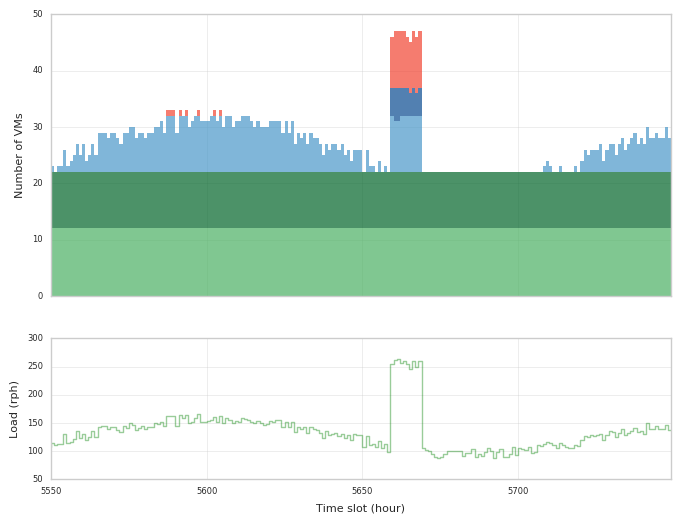

In [48]:
# Zoom around the spike (not shown in the paper)
xlim = zoom

with matplotlib.style.context(paper_style):
    # Two subplots, one for the allocation, another for the workload
    f, axarr = plt.subplots(2, sharex=True, gridspec_kw = {'height_ratios':[3, 1.5]})

    # Plot the allocations
    plot_solution_slots(phase_II.solution.get_allocation(), ax = axarr[0], 
                        linewidth=0, colors=mycolors,
                        amazon_or_azure=False, figsize=(8,6),
                        xlim = xlim, legend=False)

    # Plot the workload
    sli = slice(*xlim)
    r = range(*xlim)
    axarr[1].step(r, phase_II.solution.solving_stats.workload[sli],
                  label="original", 
                  color="green", alpha=0.4, linewidth=1)
    axarr[1].set_ylabel("Load (rph)")
    axarr[0].set_ylabel("Number of VMs")
    axarr[1].set_xlabel("Time slot (hour)")
    f.subplots_adjust(hspace=0.2)
    plt.show()

The influence of using binning in Phase I is twofold: first, the number of pre-computed allocations from Phase I is much smaller; second, and more crucially, the number of reserved instances obtained in Phase I is no longer optimal, so the cost of Phase II solution will be greater when binning was used in Phase I. In this particular example, the cost of the optimal solution was already shown to be 9015.216, while the cost of Phase II for the whole reservation period, even in the case in which STWP was identical to \LTWP{} for all time slots, is 9031.700 in this example.
